In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os 
from sklearn.model_selection import train_test_split
from scipy import misc
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
from tensorflow.keras.applications.mobilenet import decode_predictions
import cv2 

from Train_code.imageGen import ImageGenerator
from Train_code.utils import *

In [2]:

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

In [5]:
base_model=MobileNet(weights='imagenet',include_top=False)

base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [6]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
preds=Dense(1,activation='tanh')(x) 

In [7]:
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128   

In [8]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath = 'best_weights.hdf5', verbose=0, save_best_only=True)

In [10]:
# # Load Training Data
load_data()
allData, allLabels = process_crop_data()

Data extracted!
Loading Cropped Data...
Loading imageArray_Ardagh-City_1513488313.68.npy Images...
Loading imageArray_Dobs-City_1513486244.82.npy Images...
Loading imageArray_E-Road_1513485049.18.npy Images...
Loading imageArray_E-Track5_1513481723.24.npy Images...
Loading imageArray_Kaaitara-City_1513487266.5.npy Images...
Loading Cropped Labels...
Loading labelsArray_Ardagh-City_1513488313.68.npy Labels...
Loading labelsArray_Dobs-City_1513486244.82.npy Labels...
Loading labelsArray_E-Road_1513485049.18.npy Labels...
Loading labelsArray_E-Track5_1513481723.24.npy Labels...
Loading labelsArray_Kaaitara-City_1513487266.5.npy Labels...
Data loaded!


In [11]:

print("Resizing data ...")
allDatatmp = np.zeros((allData.shape[0],224,224,3))
for i in range(allData.shape[0]):#allData.shape[0]):
    allDatatmp[i,:,:,:] = cv2.resize(allData[i,:,:,:],(224,224)).astype(np.float16)/255.0
    if(i%1000==0):
        print(str(i/allData.shape[0]*100)+'%')
    
allData = allDatatmp
steerCol = 4
allLabels = allLabels[:allData.shape[0],steerCol]
print(allData.shape)
print(allLabels.shape)
del allDatatmp

Resizing data ...
0.0%
6.666666666666667%
13.333333333333334%
20.0%
26.666666666666668%
33.33333333333333%
40.0%
46.666666666666664%
53.333333333333336%
60.0%
66.66666666666666%
73.33333333333333%
80.0%
86.66666666666667%
93.33333333333333%
(15000, 224, 224, 3)
(15000,)


In [12]:
import plotly.express as px

counts, bins = np.histogram(np.concatenate((allLabels[allLabels>.1],allLabels[allLabels<-.1])),bins=100)
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'labels', 'y':'count'})
fig.show()


In [13]:
# equalize data representation
idx_right = np.where(allLabels < -.99)
idx_left = np.where(allLabels > .99)


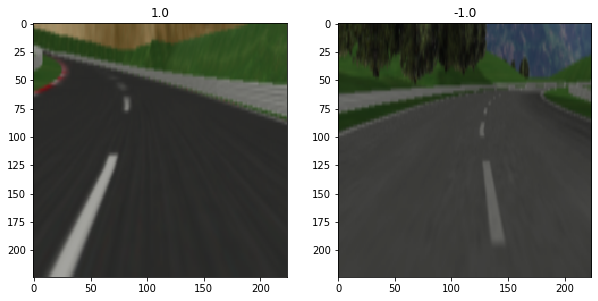

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(allData[ idx_left[0][13] ])
plt.title(str(allLabels[idx_left[0][10]]))
plt.subplot(1,2,2)
plt.imshow(allData[ idx_right[0][10] ])
plt.title(str(allLabels[idx_right[0][0]]))

plt.show()

In [16]:
x_train, y_train, x_test, y_test = train_test_split(allData,allLabels, test_size=0.2, random_state=42)

In [17]:
history = model.fit(x_train, x_test, validation_data=(y_train,y_test), callbacks=[monitor, checkpointer])

ValueError: Input arrays should have the same number of samples as target arrays. Found 12000 input samples and 3000 target samples.